## BÀI THỰC HÀNH 2: CÁC KỸ THUẬT TỐI ƯU HOÁ MÔ HÌNH
## MSSV:19521872.
## Họ Tên:Trần Nhật Nam.

## Câu 1: Thực hiện huấn luyện mô hình mạng neural ở Mục 3 trên bộ dữ liệu MNIST. 

In [43]:
import tensorflow as tf
import math


class AngularGrad(tf.keras.optimizers.Optimizer):
  def __init__(
      self,
      method_angle: str = "cos",
      learning_rate=1e-3,
      beta_1=0.9,
      beta_2=0.999,
      eps=1e-7,
      name: str = "AngularGrad",
      **kwargs,
  ):
    super().__init__(name, **kwargs)

    self.method_angle = method_angle
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("beta_1", beta_1)
    self._set_hyper("beta_2", beta_2)
    self._set_hyper("eps", eps)
    self.eps = eps or tf.keras.backend.epsilon()

  def _create_slots(self, var_list):
    for var in var_list:
      self.add_slot(var, "exp_avg")
      self.add_slot(var, "exp_avg_sq")
      self.add_slot(var, "previous_grad")
      self.add_slot(var, "min", initializer=tf.keras.initializers.Constant(value=math.pi / 2))
      self.add_slot(var, "final_angle_function_theta")

  def _resource_apply_dense(self, grad, var):
    var_dtype = var.dtype.base_dtype

    lr = self._get_hyper("learning_rate", var_dtype)
    beta_1 = self._get_hyper("beta_1", var_dtype)
    beta_2 = self._get_hyper("beta_2", var_dtype)
    eps = self._get_hyper("eps", var_dtype)

    exp_avg = self.get_slot(var, "exp_avg")
    exp_avg_sq = self.get_slot(var, "exp_avg_sq")
    previous_grad = self.get_slot(var, "previous_grad")
    min = self.get_slot(var, "min")
    final_angle_function_theta = self.get_slot(var, "final_angle_function_theta")

    step = tf.cast(self.iterations + 1, var_dtype)
    beta_1_power = tf.pow(beta_1, step)
    beta_2_power = tf.pow(beta_2, step)

    new_exp_avg = exp_avg.assign(
        beta_1 * exp_avg + (1.0 - beta_1) * grad,
        use_locking=self._use_locking
    )
    exp_avg_corrected = new_exp_avg / (1.0 - beta_1_power)

    new_exp_avg_sq = exp_avg_sq.assign(
        beta_2 * exp_avg_sq + (1.0 - beta_2) * tf.square(grad),
        use_locking=self._use_locking,
    )
    exp_avg_sq_corrected = new_exp_avg_sq / (1.0 - beta_2_power)

    tan_theta = tf.abs((previous_grad - grad) / (1 + previous_grad * grad))
    cos_theta = 1 / tf.sqrt(1 + tf.square(tan_theta))

    angle = tf.atan(tan_theta) * (180 / math.pi)
    ans = tf.greater(angle, min)
    mean_ans = tf.reduce_mean(tf.cast(ans, tf.float32))

    def true_fn():
      new_min = min.assign(angle, use_locking=self._use_locking)
      new_final_angle_function_theta = final_angle_function_theta.assign(
          tf.identity(tan_theta if self.method_angle == "tan" else cos_theta),
          use_locking=self._use_locking
      )
      return new_min, new_final_angle_function_theta

    def false_fn():
      return min, final_angle_function_theta

    new_min, new_final_angle_function_theta = tf.cond(tf.less(mean_ans, 0.5), true_fn, false_fn)
    angular_coeff = tf.tanh(tf.abs(final_angle_function_theta)) * 0.5 + 0.5

    var_update = var.assign_sub(
        lr * exp_avg_corrected * angular_coeff / (tf.sqrt(exp_avg_sq_corrected) + eps),
        use_locking=self._use_locking
    )

    new_previous_grad = previous_grad.assign(grad, use_locking=self._use_locking)

    updates = [var_update, new_exp_avg, new_exp_avg_sq, new_min, new_previous_grad, new_final_angle_function_theta]
    return tf.group(*updates)

  def _resource_apply_sparse(self, grad, var, indices):
    raise NotImplementedError

  def get_config(self):
    config = super().get_config()
    config.update(
        {
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "beta_1": self._serialize_hyperparameter("beta_1"),
            "beta_2": self._serialize_hyperparameter("beta_2"),
            "eps": self._serialize_hyperparameter("eps")
        }
    )
    return config

In [51]:
# import ảnh.
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0


In [54]:
# Xây dựng mô hình.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

# AngularGrad(cos)
optimizer = AngularGrad("cos")

# AngularGrad(tan)
# optimizer = AngularGrad("tan")

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history= model.fit(train_images, train_labels, validation_split =0.2, epochs=10)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

Epoch 1/10
1500/1500 [==============================] - 11s 6ms/step - loss: 0.5278 - accuracy: 0.8161 - val_loss: 0.4605 - val_accuracy: 0.8385
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3968 - accuracy: 0.8581 - val_loss: 0.3859 - val_accuracy: 0.8626
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3527 - accuracy: 0.8722 - val_loss: 0.3515 - val_accuracy: 0.8727
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3265 - accuracy: 0.8817 - val_loss: 0.3526 - val_accuracy: 0.8737
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3075 - accuracy: 0.8871 - val_loss: 0.3371 - val_accuracy: 0.8823
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2905 - accuracy: 0.8923 - val_loss: 0.3409 - val_accuracy: 0.8788
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2800 - accuracy: 0.8964 - val_loss: 0.3331 - val_accuracy

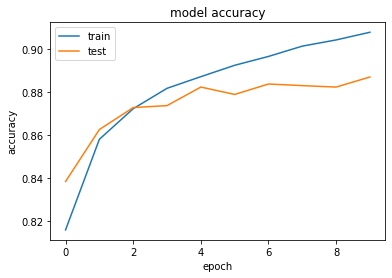

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

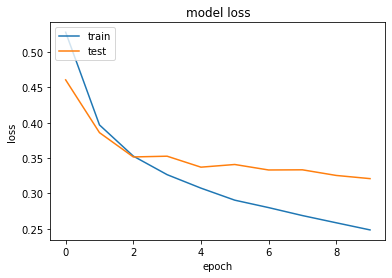

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
